# SIRS model

In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
from blackbirds.models.sirs import SIRS
from blackbirds.infer import VI
from blackbirds.utils import soft_minimum, soft_maximum
from blackbirds.simulate import simulate_and_observe_model

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx
import normflows as nf
import pygtc

Following Dyer et al we fix

In [185]:
i0 = 0.1
n_timesteps = 100
N = 100

model = SIRS(n_timesteps=n_timesteps, i0=i0, N=N)

In [677]:
log_alpha = np.log(.5)
log_beta = np.log(.3)
log_gamma = np.log(0.5)

true_parameters = torch.tensor([log_alpha, log_beta, log_gamma])
# torch.manual_seed(0)
x = model.run(true_parameters)

true_data = model.observe(x)
SIR = model.reconstruct_series(true_data[0])

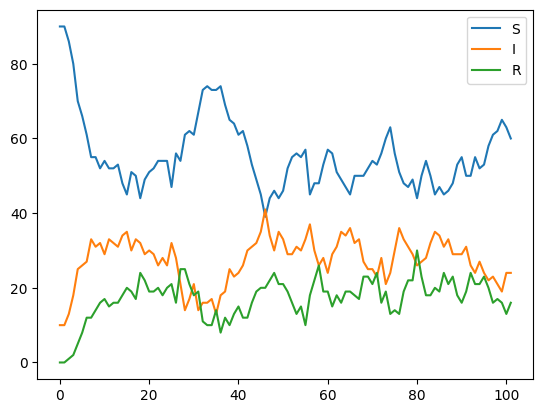

In [678]:
plt.plot(SIR.cpu(), label=["S", "I", "R"])
plt.legend()

tensor([-0.7143,  0.3662,  1.0743])


(0.0, 100.0)

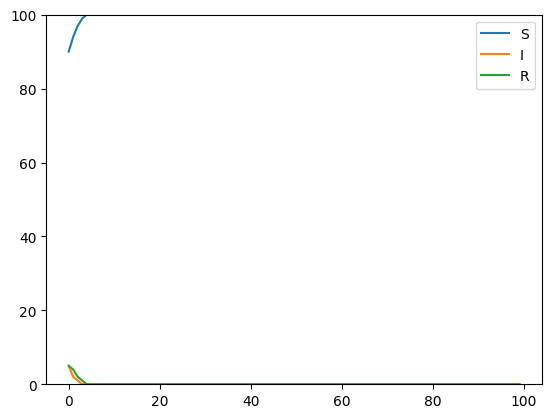

In [623]:
prior_sample = prior.sample((1,))[0]
print(prior_sample)
x = model.run(prior_sample)
prior_pred = x[1:, :3]
plt.plot(prior_pred.cpu(), label=["S", "I", "R"])
plt.legend()
plt.ylim([0,100])

In [285]:
latent_size = len(true_parameters)

def make_flow():
    torch.manual_seed(0)
    base = nf.distributions.base.DiagGaussian(latent_size)
    num_layers = 1
    flows = []
    for i in range(num_layers):
        param_map = nf.nets.MLP([2, 50, 50, latent_size], init_zeros=True)
#         flows.append(nf.flows.AffineCouplingBlock(param_map))
        flows.append(nf.flows.Permute(latent_size, mode='swap'))
    return nf.NormalizingFlow(base, flows)

#### Pathwise

In [698]:
prior = torch.distributions.MultivariateNormal(torch.zeros(latent_size), 
                                               torch.eye(latent_size))
estimator = make_flow()
print(estimator.sample())
loss = model.negative_log_likelihood
optimizer = torch.optim.AdamW(estimator.parameters(), lr=5e-3)
vi = VI(loss = loss, 
        posterior_estimator=estimator, 
        prior=prior, 
        optimizer=optimizer, 
        n_samples_per_epoch=10,
        w=1.,
        log_tensorboard=True,
        gradient_estimation_method="pathwise",
        gradient_clipping_norm=10.0,
        gradient_horizon=None
    )

vi.run(true_data[0][:, -3:], n_epochs=1, max_epochs_without_improvement=50);

(tensor([[ 0.9483, -0.1538, -0.0412]], grad_fn=<CatBackward0>), tensor([-3.2191], grad_fn=<SubBackward0>))


  0%|                                                                                                                                                                                 | 0/1 [00:00<?, ?it/s]

GradTrackingTensor(lvl=1, value=
    tensor([0.2501, 0.4419, 0.4596])
) tensor([[ 0.,  0.,  0.],
        [ 0.,  4.,  1.],
        [ 1.,  7.,  2.],
        [ 1., 11.,  4.],
        [ 2.,  6.,  5.],
        [ 2.,  7.,  6.],
        [ 4., 10.,  4.],
        [ 6.,  6.,  8.],
        [ 6.,  9.,  8.],
        [ 8.,  6.,  9.],
        [ 5.,  7.,  3.],
        [ 7.,  7.,  8.],
        [ 9.,  8.,  9.],
        [ 5., 10.,  7.],
        [ 8., 11., 10.],
        [12.,  6., 11.],
        [ 8.,  9.,  6.],
        [ 4., 10., 11.],
        [ 9.,  4.,  7.],
        [10.,  8.,  7.],
        [ 9.,  8.,  9.],
        [10.,  8., 11.],
        [ 6.,  6.,  4.],
        [ 6.,  6.,  8.],
        [ 5., 12.,  6.],
        [14.,  5.,  9.],
        [ 2.,  4., 11.],
        [ 9.,  2.,  9.],
        [ 8.,  7.,  4.],
        [ 8.,  9.,  5.],
        [ 8.,  2.,  9.],
        [11.,  5.,  3.],
        [ 5.,  4.,  4.],
        [ 4.,  5.,  4.],
        [ 3.,  3.,  7.],
        [ 9.,  8.,  3.],
        [ 2.,  7.,  6.],
   

GradTrackingTensor(lvl=1, value=
    tensor([-1.0323, -0.4692,  0.7801])
) tensor([[ 0.,  0.,  0.],
        [ 0.,  4.,  1.],
        [ 1.,  7.,  2.],
        [ 1., 11.,  4.],
        [ 2.,  6.,  5.],
        [ 2.,  7.,  6.],
        [ 4., 10.,  4.],
        [ 6.,  6.,  8.],
        [ 6.,  9.,  8.],
        [ 8.,  6.,  9.],
        [ 5.,  7.,  3.],
        [ 7.,  7.,  8.],
        [ 9.,  8.,  9.],
        [ 5., 10.,  7.],
        [ 8., 11., 10.],
        [12.,  6., 11.],
        [ 8.,  9.,  6.],
        [ 4., 10., 11.],
        [ 9.,  4.,  7.],
        [10.,  8.,  7.],
        [ 9.,  8.,  9.],
        [10.,  8., 11.],
        [ 6.,  6.,  4.],
        [ 6.,  6.,  8.],
        [ 5., 12.,  6.],
        [14.,  5.,  9.],
        [ 2.,  4., 11.],
        [ 9.,  2.,  9.],
        [ 8.,  7.,  4.],
        [ 8.,  9.,  5.],
        [ 8.,  2.,  9.],
        [11.,  5.,  3.],
        [ 5.,  4.,  4.],
        [ 4.,  5.,  4.],
        [ 3.,  3.,  7.],
        [ 9.,  8.,  3.],
        [ 2.,  7.,  6.],


100%|██████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s, loss=3.51e+3, reg.=1e-9, total=3.51e+3, best loss=3.51e+3, epochs since improv.=0]

GradTrackingTensor(lvl=1, value=
    tensor([ 0.4201, -1.2437, -0.6035])
) tensor([[ 0.,  0.,  0.],
        [ 0.,  4.,  1.],
        [ 1.,  7.,  2.],
        [ 1., 11.,  4.],
        [ 2.,  6.,  5.],
        [ 2.,  7.,  6.],
        [ 4., 10.,  4.],
        [ 6.,  6.,  8.],
        [ 6.,  9.,  8.],
        [ 8.,  6.,  9.],
        [ 5.,  7.,  3.],
        [ 7.,  7.,  8.],
        [ 9.,  8.,  9.],
        [ 5., 10.,  7.],
        [ 8., 11., 10.],
        [12.,  6., 11.],
        [ 8.,  9.,  6.],
        [ 4., 10., 11.],
        [ 9.,  4.,  7.],
        [10.,  8.,  7.],
        [ 9.,  8.,  9.],
        [10.,  8., 11.],
        [ 6.,  6.,  4.],
        [ 6.,  6.,  8.],
        [ 5., 12.,  6.],
        [14.,  5.,  9.],
        [ 2.,  4., 11.],
        [ 9.,  2.,  9.],
        [ 8.,  7.,  4.],
        [ 8.,  9.,  5.],
        [ 8.,  2.,  9.],
        [11.,  5.,  3.],
        [ 5.,  4.,  4.],
        [ 4.,  5.,  4.],
        [ 3.,  3.,  7.],
        [ 9.,  8.,  3.],
        [ 2.,  7.,  6.],


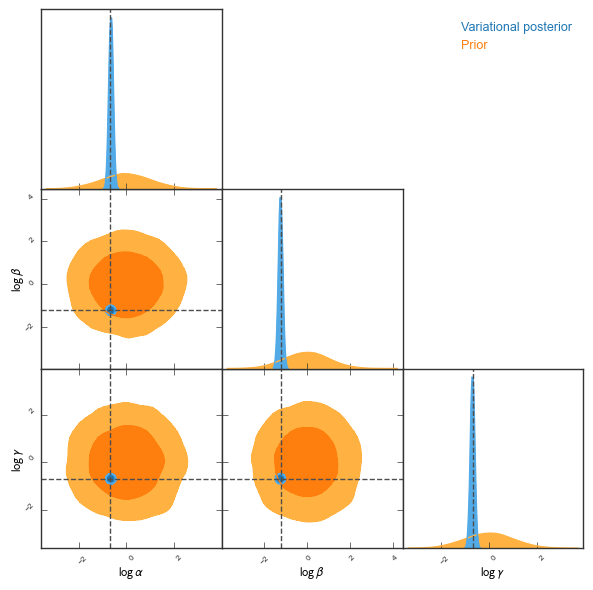

In [680]:
# We can load the best model to check the results
estimator.load_state_dict(vi.best_estimator_state_dict)

# Plot the final flow posterior approximator and compare it to the real parameters:
samples = estimator.sample(10000)[0].detach().numpy()
samples_prior = prior.sample((10000,)).numpy()

pygtc.plotGTC([samples, samples_prior], 
              figureSize=7, 
              truths = true_parameters.numpy(), 
              chainLabels = ["Variational posterior", "Prior"],
              paramNames = [r"$\log \alpha$", r"$\log \beta$", r"$\log \gamma$"],);
#corner(samples, truths=true_parameters.numpy(), smooth=2);#, range=[(0,1) for i in range(3)]+ [(-1,0)]);

plt.savefig("./vi4abms/likelihood_pathwise/sirs.pdf", format='pdf', dpi=300, bbox_inches='tight')

#### Score

In [298]:
estimator = make_flow()

b = 1e3

def cv_nll(theta, y):
    
    return model.negative_log_likelihood(theta, y) - b

loss = cv_nll
optimizer = torch.optim.AdamW(estimator.parameters(), lr=1e-3)
vi = VI(loss = loss, 
        posterior_estimator=estimator, 
        prior=prior, 
        optimizer=optimizer, 
        n_samples_per_epoch=50,
        w=1.,
        log_tensorboard=True,
        gradient_estimation_method="score",
        gradient_clipping_norm=10.0,
        gradient_horizon=None
    )

vi.run(data[0][:, -3:], n_epochs=1000, max_epochs_without_improvement=50);

 19%|███████████████▌                                                                | 194/1000 [03:15<13:33,  1.01s/it, loss=1.7e+3, reg.=0.0913, total=1.71e+3, best loss=1.4e+3, epochs since improv.=50]


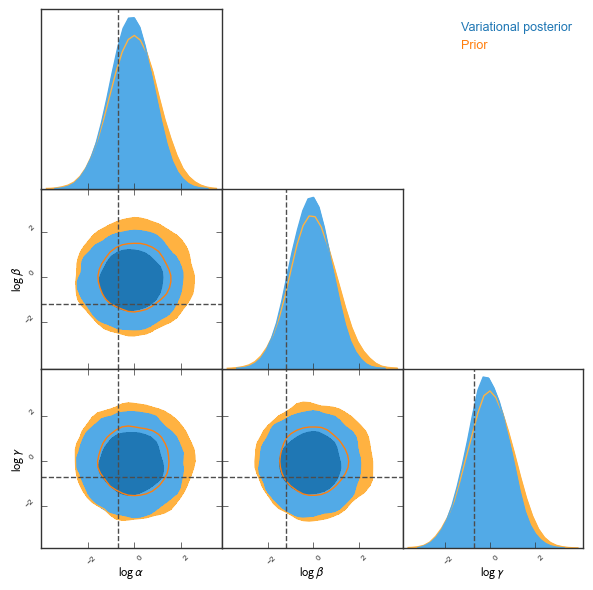

In [299]:
# We can load the best model to check the results
estimator.load_state_dict(vi.best_estimator_state_dict)

# Plot the final flow posterior approximator and compare it to the real parameters:
samples = estimator.sample(10000)[0].detach().numpy()
samples_prior = prior.sample((10000,)).numpy()

pygtc.plotGTC([samples, samples_prior], 
              figureSize=7, 
              truths = true_parameters.numpy(), 
              chainLabels = ["Variational posterior", "Prior"],
              paramNames = [r"$\log \alpha$", r"$\log \beta$", r"$\log \gamma$"],);
#corner(samples, truths=true_parameters.numpy(), smooth=2);#, range=[(0,1) for i in range(3)]+ [(-1,0)]);

plt.savefig("./vi4abms/likelihood_score/sirs.pdf", format='pdf', dpi=300, bbox_inches='tight')

#### LF-VI with DRE

In [645]:
import blackbirds.ratio_estimation as ratio_estimation
import blackbirds.networks as networks

import logging
logging.getLogger("ratio").setLevel(logging.INFO)

In [646]:
N_TOTAL = 1_000

In [647]:
def simulator(theta):
    
    x = model.run(theta)
    data = model.observe(x)
    out = data[0].reshape(1, -1, 3)
#     out = x[:, 1:3].unsqueeze(0)
    return out

In [714]:
# SIMULATE TRAINING DATA
theta, x = ratio_estimation.generate_training_data(simulator, prior, n_training_samples=N_TOTAL)

In [715]:
n_summaries = 16
rnn_hidden_size = 32

linear_layer = torch.nn.Linear(rnn_hidden_size, n_summaries)

summariser = networks.RNN(input_size=x.size(-1),
                          hidden_size=rnn_hidden_size,
                          num_layers=2,
                          final_ff=linear_layer,
                          flavour='gru'
                         )

# n_summaries = 2*4

# class Summariser(torch.nn.Module):
    
#     def __init__(self):
        
#         super().__init__()
        
#     def forward(self, x):
        
#         means = x.mean(dim=1)
#         stds = x.std(dim=1)
#         maxs = x.amax(dim=1)
#         prop_zeros = (x == 0.).float().mean(dim=1)
        
#         out = torch.cat((means, stds, maxs, prop_zeros), dim=-1)
# #         print(out)
#         return out
    
# summariser = Summariser()

classifier = networks.MLP(input_dim=latent_size + n_summaries,
                          hidden_dims=[32, 32],
                          output_dim=1)

ratio_estimator = ratio_estimation.RatioEstimator(classifier_network=classifier, summary_network=summariser)

assert networks.count_pars(ratio_estimator) == networks.count_pars(classifier) + networks.count_pars(summariser)
assert networks.count_pars(ratio_estimator) > 0
print(networks.count_pars(ratio_estimator))

12145


In [716]:
# Normalise for training
x_normalised = x / N
# x_normalised = torch.cumsum(x, dim=1)
# x_normalised = x_normalised / x_normalised.max()
# summarised = summariser(x_normalised)
# print(summarised, summarised.shape)
# x_normalised = x_normalised[:, 1:, :]

In [717]:
theta_normalised = theta

In [718]:
TRAIN_PROP = 0.8
N_TRAIN = int(TRAIN_PROP * N_TOTAL)
N_VAL = N_TOTAL - N_TRAIN

ratio_optimizer = torch.optim.Adam(ratio_estimator.parameters(), lr=5e-3)
ratio_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(ratio_optimizer, factor=0.5, patience=30)

best_ratio_estimator, loss_hist = ratio_estimation.train(x_normalised[:N_TRAIN],
                                                         theta_normalised[:N_TRAIN],
                                                         x_normalised[N_TRAIN:],
                                                         theta_normalised[N_TRAIN:],
                                                         ratio_estimator,
                                                         ratio_optimizer,
                                                         ratio_scheduler=ratio_scheduler,
                                                         max_iterations_without_val_loss_improvement=50,
                                                         max_num_epochs=1000
                                                        )

 28%|██████████████████▋                                                 | 275/1000 [01:47<04:42,  2.56it/s, train_loss=0.133, best_val_loss=0.303, current_val_loss=0.351, steps since last improvement=50]


In [719]:
estimator = make_flow()
print(estimator.sample())

def ratio_nll(theta, y):
    
    if not len(y.shape) == 3:
        y = y.unsqueeze(0)
    sy = best_ratio_estimator.sn_forward(y)
    sy = sy.detach().clone()
    ll = best_ratio_estimator.log_ratio(sy, theta)
    return -ll

loss = ratio_nll

optimizer = torch.optim.AdamW(estimator.parameters(), lr=1e-2)
vi = VI(loss = loss, 
        posterior_estimator=estimator, 
        prior=prior, 
        optimizer=optimizer, 
        n_samples_per_epoch=50,
        w=1.,
        log_tensorboard=True,
        gradient_estimation_method="pathwise",
        gradient_clipping_norm=10.0,
        gradient_horizon=None
    )

vi.run(true_data[0][None, :, -3:] / N, n_epochs=1000, max_epochs_without_improvement=50);

(tensor([[ 0.9483, -0.1538, -0.0412]], grad_fn=<CatBackward0>), tensor([-3.2191], grad_fn=<SubBackward0>))


 29%|████████████████████████▋                                                           | 294/1000 [01:23<03:21,  3.51it/s, loss=-4.25, reg.=4.59, total=0.343, best loss=0.00843, epochs since improv.=50]


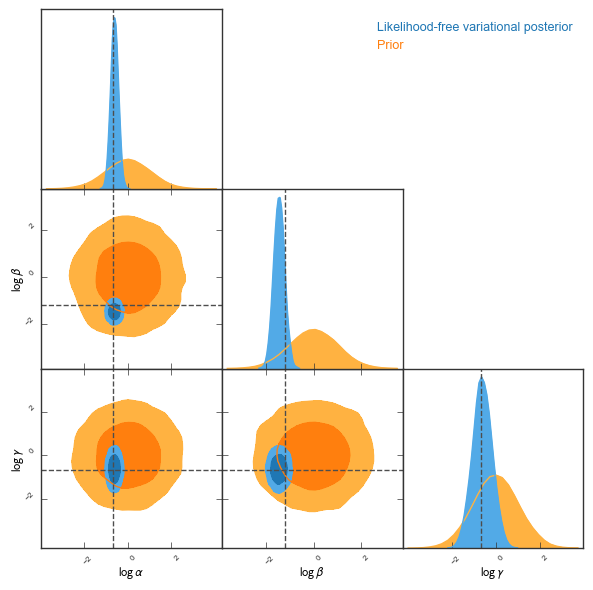

In [722]:
# We can load the best model to check the results
estimator.load_state_dict(vi.best_estimator_state_dict)

# Plot the final flow posterior approximator and compare it to the real parameters:
samples = estimator.sample(10000)[0].detach().numpy()
samples_prior = prior.sample((10000,)).numpy()

pygtc.plotGTC([samples, samples_prior], 
              figureSize=7, 
              truths = true_parameters.numpy(), 
              chainLabels = ["Likelihood-free variational posterior", "Prior"],
              paramNames = [r"$\log \alpha$", r"$\log \beta$", r"$\log \gamma$"],);
#corner(samples, truths=true_parameters.numpy(), smooth=2);#, range=[(0,1) for i in range(3)]+ [(-1,0)]);

plt.savefig("./vi4abms/likelihood_free/sirs.pdf", format='pdf', dpi=300, bbox_inches='tight')